In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
store_sales = pd.read_csv('https://raw.githubusercontent.com/BekBrace/Sales-Forecast-data-csv/main/train.csv')

In [3]:
store_sales.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
store_sales.shape

(913000, 4)

In [5]:
store_sales.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [6]:
# Check for null values in the dataset
store_sales.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [7]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [8]:
#Dropping store and item columns
store_sales = store_sales.drop(['store', 'item'], axis=1)

In [9]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


In [10]:
# Converting Date object dtype to datetime dtype
store_sales['date'] = pd.to_datetime(store_sales['date'])

In [11]:
# Converting Date to Month period and sum the number of items in each month
store_sales['date'] = store_sales['date'].dt.to_period('M')
monthly_sales = store_sales.groupby('date').sum().reset_index()

In [12]:
# Convert the result date column to timestamp datatype
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

In [13]:
monthly_sales.head()

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242


## Visualization

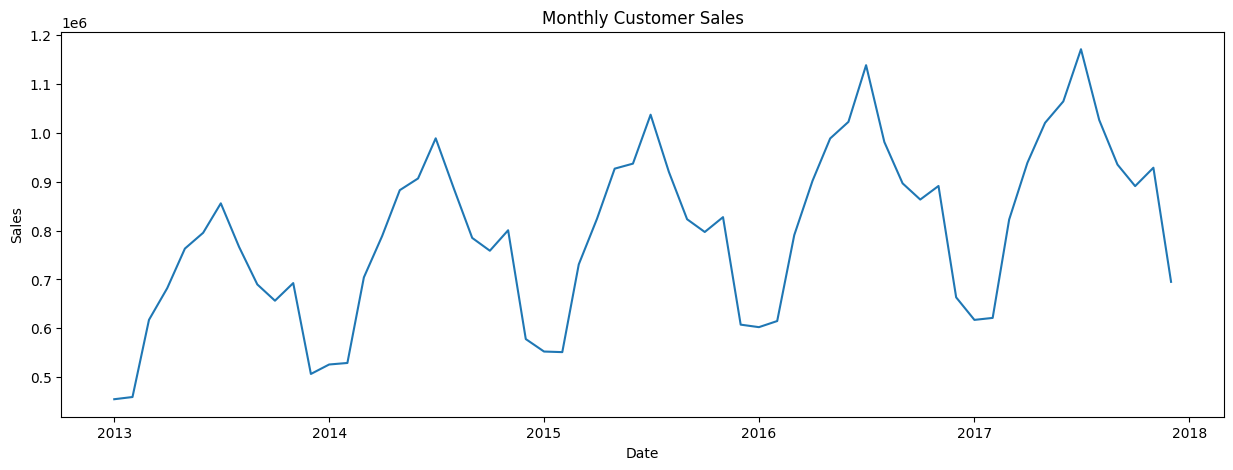

In [14]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly Customer Sales')
plt.show()

In [15]:
# Call the difference on the sales column tio make the sakes data stationary
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head()

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0


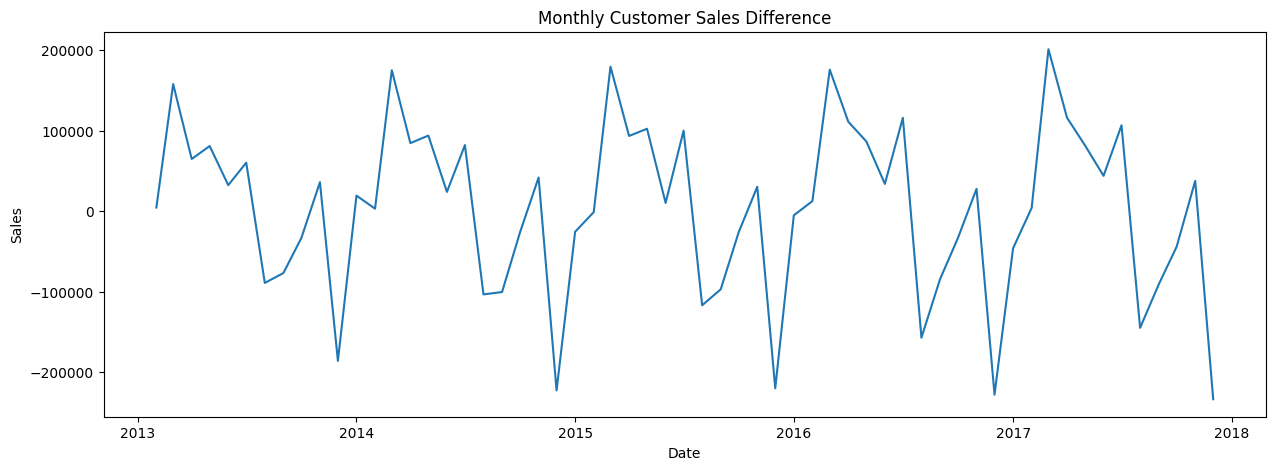

In [16]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales_diff'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly Customer Sales Difference')
plt.show()

In [17]:
# Dropping off sales and date
supervised_data = monthly_sales.drop(['date','sales'], axis=1)

In [18]:
# Prepping the supervised data
for i in range(1,13):
  col_name = 'month_' + str(i)
  supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


In [19]:
# Split the daya into Train and Test
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]
print("Train Data Shape: ", train_data.shape)
print("Test Data Shape: ", test_data.shape)

Train Data Shape:  (35, 13)
Test Data Shape:  (12, 13)


Fitting to the supervised data to scaler

In [20]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [21]:
X_train, y_train = train_data[:,1:], train_data[:,0:1]
X_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (35, 12)
y_train shape:  (35,)
X_test shape:  (12, 12)
y_test shape:  (12,)


Making Prediction Dataframe to merge the predicted sales prices of all trained algorithms.

In [22]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [23]:
actual_sales = monthly_sales['sales'][-13:].to_list()
print(actual_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


Create the linear regression model, and the predicted output

In [24]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predict =  lr_model.predict(X_test)

In [25]:
lr_predict = lr_predict.reshape(-1,1)

# This is a set matrix - contains the input features of the test data and also the predicted output
lr_predict_test_set = np.concatenate([lr_predict, X_test], axis=1)
lr_predict_test_set = scaler.inverse_transform(lr_predict_test_set)

In [26]:
result_list = []
for index in range(0, len(lr_predict_test_set)):
  result_list.append(lr_predict_test_set[index][0] + actual_sales[index])

lr_predict_series = pd.Series(result_list, name="Linear Prediction")
predict_df = predict_df.merge(lr_predict_series, left_index=True, right_index=True)

In [27]:
#print(predict_df)

Evaluation Variables

In [28]:
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
lr_r2 = r2_score(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])

print("Linear Regression MSE: ", lr_mse)
print("Linear Regression MAE: ", lr_mae)
print("Linear Regression R2: ", lr_r2)

Linear Regression MSE:  16221.272385416869
Linear Regression MAE:  12433.184266490736
Linear Regression R2:  0.9906152516380969


Visualization of the prediction against the actual sales

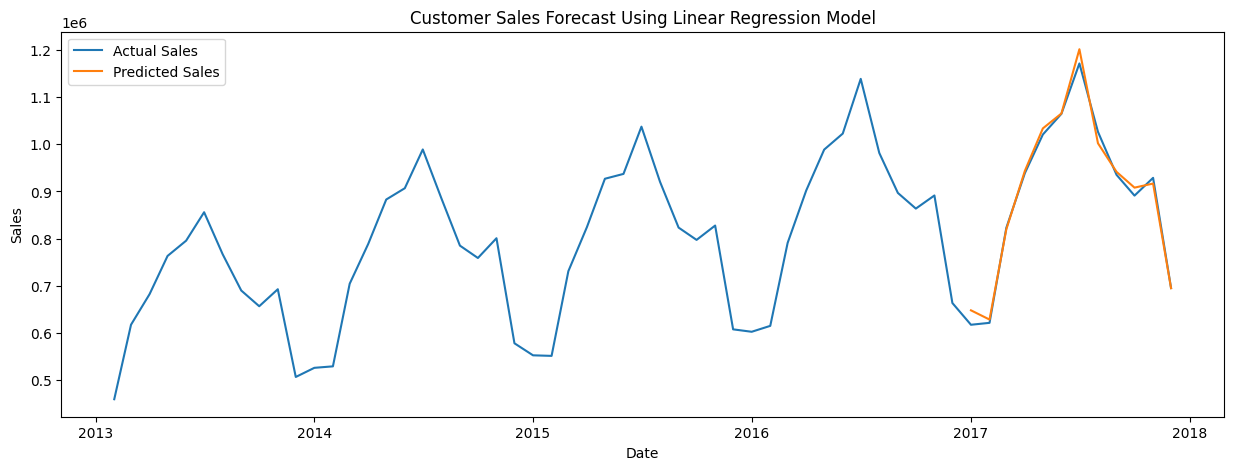

In [32]:
plt.figure(figsize=(15,5))

# Actual Sales
plt.plot(monthly_sales['date'], monthly_sales['sales'])

# Predicted Sales
plt.plot(predict_df['date'], predict_df['Linear Prediction'])
plt.title("Customer Sales Forecast Using Linear Regression Model")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(['Actual Sales', 'Predicted Sales'])
plt.show()

Observation: Thg 2017-2018 Prediction is pretty close with the Actual Sales